# PSF normalization

Let us assume that we have reduced an observation, for which we have determined the PSF by stacking the flux of point-like sources. The PSF we obtain will not be as high S/N as the instrumental PSF that has been determined by the instrument team. Moreover, it is likely to be fattened due to the some small pointing errors. We need to find out what fraction of a point-like flux the PSF we have determined represent. In order to do this, we use the growth curve of the theoretical PSF that has been determine by the instrument team, and compare it to the growth curve we determine from our PSF.


In [1]:
# import what we will need. 
%matplotlib inline
import numpy as np
from astropy.io import fits
from astropy.table import Table
from astropy.io import ascii as asciiread
from matplotlib import pyplot as plt
from scipy import interpolate 
from scipy import special
from scipy import signal
from scipy import fftpack

## 2) Real data: MIPS observations

We will look at a real stack of point sources in the MIPS ELAIS-N2 observations, and try to find its normalization factor. 

Let's load the stacked PSF:

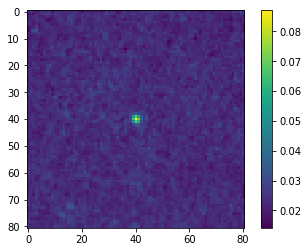

In [2]:
stackhd_im = fits.open('./AKARI-NEP/data/60096211.60096211-8.MIPS.1.help.fits')
stackhd = fits.open('./AKARI-NEP/data/60096211.60096211-8.MIPS.1.help.psf.fits')
psf = stackhd[1].data
hd = stackhd[1].header
cpix=np.int((hd['NAXIS1']+1)/2.0)
rad=40
plt.imshow(psf[cpix-rad-1:cpix+rad,cpix-rad-1:cpix+rad])
plt.colorbar()

In [3]:
resol= np.abs(stackhd[1].header['CD1_1'])/np.abs(stackhd_im[1].header['CD1_1'])

In [4]:
resol

1.0

In [5]:
hdp = stackhd[2].header

## Read in MIPS 24 $\mathrm{\mu m}$ Instrumental PSF
We take the instrumental PSF from [Gonzalo J.Aniano's webpage](http://www.astro.princeton.edu/~ganiano/Kernels/Ker_2017/PSF_FITS_Files/)

In [6]:
insthd = fits.open('./data/PSF_Original_MIPS_24.fits.gz')
psf_inst_full = insthd[0].data
hdinst = insthd[0].header


In [7]:
#hdinst


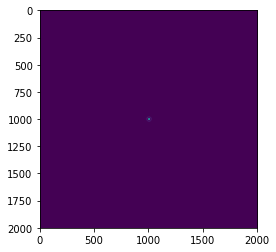

In [8]:
rad=1000
cpix=np.int((hdinst['NAXIS1']+1)/2.0)

plt.imshow(psf_inst_full[cpix-rad-1:cpix+rad,cpix-rad-1:cpix+rad])
#psf_inst=psf_inst_full[hdinst['CRPIX1']-rad-1:hdinst['CRPIX1']+rad,hdinst['CRPIX2']-rad-1:hdinst['CRPIX2']+rad]
psf_inst=psf_inst_full[cpix-rad-1:cpix+rad,cpix-rad-1:cpix+rad]

### Normalise instrumental PSF such that integral=1

In [9]:
psf_inst=psf_inst/(np.sum(psf_inst))

Now let's build the growthcurve for our PSFs.

In [10]:
# find the brightest pixel, it will be our center.
jmax, imax = np.unravel_index(np.argmax(psf), psf.shape)
jmax_inst, imax_inst = np.unravel_index(np.argmax(psf_inst), psf_inst.shape)


In [11]:
# build the array of coordinates
x = np.arange(hd['NAXIS1'])
y = np.arange(hd['NAXIS2'])
xv, yv = np.meshgrid(x, y, sparse=False, indexing='xy')
xp = (xv-imax)*np.abs(hd['CD1_1'])*3600.
yp = (yv-jmax)*np.abs(hd['CD2_2'])*3600.
r = np.sqrt(xp**2 + yp**2)

x_inst = np.arange(1+rad*2)
y_inst = np.arange(1+rad*2)
xv_inst, yv_inst = np.meshgrid(x_inst, y_inst, sparse=False, indexing='xy')
xp_inst = (xv_inst-imax_inst)*np.abs(hdinst['CD1_1']*3600.0)
yp_inst = (yv_inst-jmax_inst)*np.abs(hdinst['CD1_1']*3600.0)
r_inst = np.sqrt(xp_inst**2 + yp_inst**2)

In [12]:
# build the growth curve
radii = np.unique(r)
encircled_flux = np.zeros(radii.shape)
nbpix = np.zeros(radii.shape)
for i, radius in enumerate(radii):
    idj, idi = np.where(r <= radius)
    nbpix[i] =len(idi)
    encircled_flux[i] = np.sum(psf[idj, idi])*resol**2
    #multiply by ((np.abs(hd['CDELT1'])*3600.)**2)/4.25E10 as map is in units of MJy/sr
    #encircled_flux[i] = np.sum(psf[idj, idi])*((np.abs(hd['CD1_1'])*3600.)**2)/4.25E10

Normally we run the code below for the instrumental PSF. This is slow and remains the same for each field so I just load up the result instead.

```python
radii_inst = np.unique(r_inst)
encircled_flux_inst = np.zeros(radii_inst.shape)
nbpix_inst = np.zeros(radii_inst.shape)
for i, radius in enumerate(radii_inst):
    if i % 1000 == 0:
        print(i,len(radii_inst))
    idj, idi = np.where(r_inst <= radius)
    nbpix_inst[i] =len(idi)
    encircled_flux_inst[i] = np.sum(psf_inst[idj, idi])
```  

In [13]:
inst_data=np.load('./data/MIPS_encircled_flux_inst.npz')
encircled_flux_inst=inst_data['encircled_flux_inst']
radii_inst=inst_data['radii_inst']

Text(0, 0.5, 'Encircled flux')

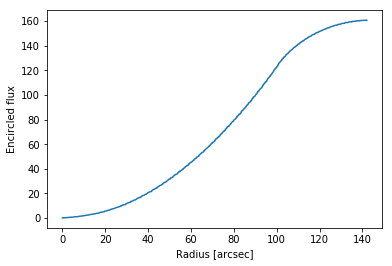

In [14]:
plt.plot(radii, encircled_flux)

plt.xlabel('Radius [arcsec]')
plt.ylabel('Encircled flux')

Looking at the shape of the encircled flux, it looks like the background level of our PSF is not zero. Let's check

In [15]:
# This is clearly. 
print(np.median(psf[0:5,:]))

0.022899685


Text(0, 0.5, 'Encircled flux')

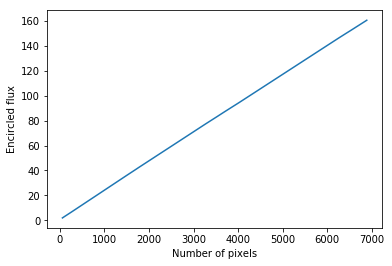

In [16]:
plt.plot(nbpix[10:], encircled_flux[10:])
plt.xlabel('Number of pixels')
plt.ylabel('Encircled flux')

In [17]:
print('len:' , len(nbpix))
print(nbpix[50])

len: 777
373.0


In [20]:
# Lets do a linear fit to the outer part of the curve to determine the backgound
p = np.polyfit(nbpix[50:], encircled_flux[50:], 1)
#bkg=p[0]/(((np.abs(hd['CD1_1'])*3600.)**2)/4.25E10)
bkg = p[0]/resol**2

In [21]:
print(bkg)

0.02320506763625044


In [22]:
#print(nbpix[100:])

In [24]:
# Lets correct the psf and encircled flux
psf = psf - bkg
encircled_flux = encircled_flux - p[0]* nbpix

Text(0, 0.5, 'Encircled flux')

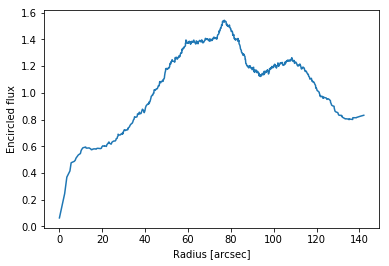

In [25]:
plt.plot(radii, encircled_flux)
plt.xlabel('Radius [arcsec]')
plt.ylabel('Encircled flux')

Our PSF does now behaves correctly.

Now let us compare our growth curve with the encircled energy curve from the instrumental PSF.  

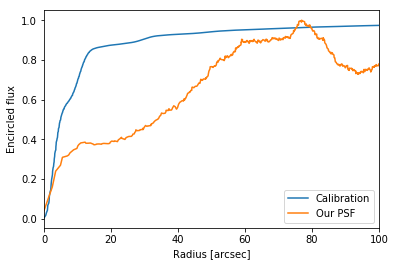

In [26]:
plt.plot(radii_inst, encircled_flux_inst, label='Calibration')
plt.plot(radii, encircled_flux/np.max(encircled_flux), label='Our PSF')
plt.xlim([0, 100])
plt.xlabel('Radius [arcsec]')
plt.ylabel('Encircled flux')
plt.legend()

We will work below 30" where our PSF is well behaved

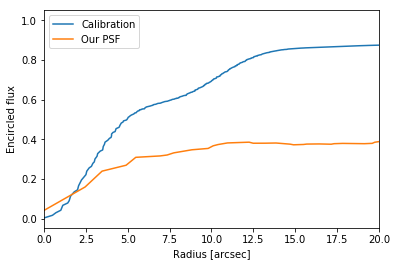

In [27]:
plt.plot(radii_inst, encircled_flux_inst, label='Calibration')
plt.plot(radii, encircled_flux/np.max(encircled_flux), label='Our PSF')
plt.xlim([0, 20])
plt.xlabel('Radius [arcsec]')
plt.ylabel('Encircled flux')
plt.legend()

We see that while the calibration curve still rises beyond 30", our PSF has reached a plateau. Let's note the calibration $C(r)$. Our PSF encirled energy is of the form:

$E(r) = \alpha C(r \times \beta)$

Where $\beta$ is the fattening of the PSF.

We could take the derivative, but this too noisy. Instead we do a brute force approach

Seb's suggestion.. look at derivative!! Also see how correction parameters change as a function of where I do correction

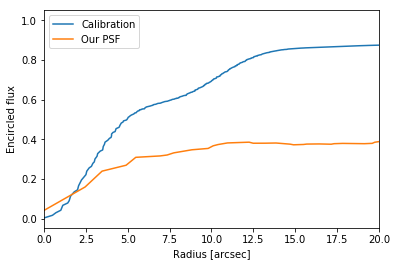

In [28]:
plt.plot(radii_inst, encircled_flux_inst, label='Calibration')
plt.plot(radii, encircled_flux/np.max(encircled_flux), label='Our PSF')
plt.xlim([0, 20])
plt.xlabel('Radius [arcsec]')
plt.ylabel('Encircled flux')
plt.legend()

In [29]:
rfactor = np.arange(0.5,3., 1e-2)
ffactor = np.arange(0.5,3., 1e-2)
# work with the data points between 3 and 25"
for r in np.arange(3,6):
    idx, = np.where((radii > 2) & (radii < r))
    xv = radii[idx]
    yv = encircled_flux[idx]/np.max(encircled_flux)
    resid = np.zeros((len(rfactor), len(ffactor)))
    for i, rf in enumerate(rfactor):
        tck = interpolate.splrep(radii_inst*rf,encircled_flux_inst , s=1)#changed s=0 to 1 as I was getting NaNs
        yfit = interpolate.splev(xv, tck, der=0)

        for j, ff in enumerate(ffactor):
            resid[i, j] = np.sum((yv-yfit*ff)**2)
    imin = np.argmin(resid)
    rmin, fmin = np.unravel_index(imin, resid.shape)
    print("rf = {:.3f}, ff = {:.3f}, residual = {:.3f}".format(rfactor[rmin], ffactor[fmin], resid[rmin, fmin]))
    print(np.max((psf/np.max(encircled_flux)/ffactor[fmin])))
    

rf = 2.790, ff = 0.740, residual = 0.000
0.055927344
rf = 0.800, ff = 0.500, residual = 0.001
0.08277247
rf = 0.800, ff = 0.500, residual = 0.001
0.08277247


This shows a minimum, with some degeneracy. 

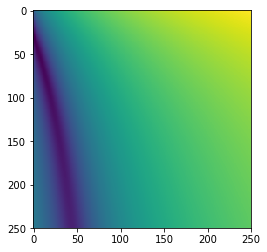

In [30]:
plt.imshow(np.log(resid))

In [31]:
imin = np.argmin(resid)
rmin, fmin = np.unravel_index(imin, resid.shape)
print("rf = {:.3f}, ff = {:.3f}, residual = {:.3f}".format(rfactor[rmin], ffactor[fmin], resid[rmin, fmin]))

rf = 0.800, ff = 0.500, residual = 0.001


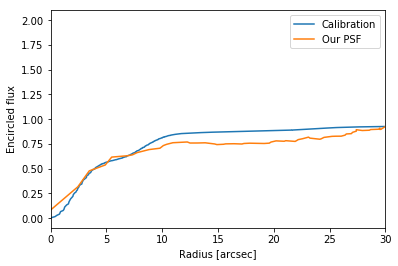

In [32]:
plt.plot(radii_inst*rfactor[rmin],encircled_flux_inst, label='Calibration')
plt.plot(radii, encircled_flux/np.max(encircled_flux)/ffactor[fmin], label='Our PSF')
plt.xlim([0, 30])
plt.xlabel('Radius [arcsec]')
plt.ylabel('Encircled flux')
plt.legend()

In [33]:
# The two curve overlap
rad=20
psfok = (psf/np.max(encircled_flux)/ffactor[fmin])
cpix=np.int((hd['NAXIS1']+1)/2.0)
#np.sum(psfok[cpix-rad-1:cpix+rad,cpix-rad-1:cpix+rad])*((np.abs(hd['CD1_1'])*3600.)**2)/4.25E10
np.sum(psfok[cpix-rad-1:cpix+rad,cpix-rad-1:cpix+rad])

1.5800571

psfok is the PSF that a source of flux 1 Jy has in our data, and is to be used for source extraction.
## As units of map in MJy/sr, divide by 1E6

In [34]:
np.max(psfok)

0.08277247

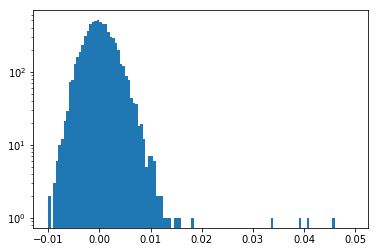

In [35]:
plt.hist(psfok.flatten(),bins=np.arange(-0.01,0.05,0.0005));
plt.yscale('log')

In [ ]:
#psfok=psfok/1.0E6

## Validation
To check PSF is reasonable, lets look at a 24 micron source (Spitzer index 201233 in spitzer-cat-full-master-mips24.fits) that has a flux of 812.65 microJy. Maximum value in our normalised PSF gives a peak below. Since PSF is double resolution of map, it could also be off centre. Map has value of 0.5315 MJy/sr but does appear to be off centre. 

In [43]:
print("Max PSF = {:.5f} uJy/pix, off pixel Max PSF = {:.5f} uJy/pix".format(psfok[cpix-1,cpix-1]*8.12E2,psfok[cpix-2,cpix-2]*8.12E2))

Max PSF = 67.21125 uJy/pix, off pixel Max PSF = 33.16857 uJy/pix


/home/mc741/anaconda3/lib/python3.6/site-packages/mpl_toolkits/axes_grid/__init__.py:12: MatplotlibDeprecationWarning: 
The mpl_toolkits.axes_grid module was deprecated in Matplotlib 2.1 and will be removed two minor releases later. Use mpl_toolkits.axes_grid1 and mpl_toolkits.axisartist provies the same functionality instead.
  obj_type='module')
keyword looks very much like CRVALia but isn't. [astropy.wcs.wcs]
keyword looks very much like CRVALia but isn't. [astropy.wcs.wcs]


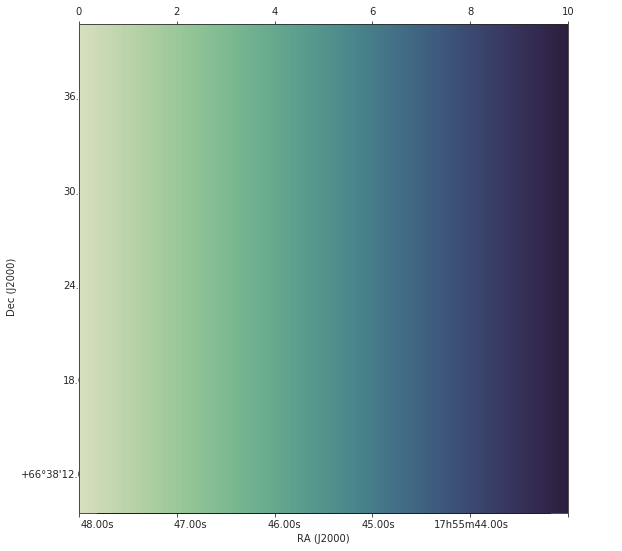

In [45]:
import aplpy
import seaborn as sns
sns.set_style("white")
cmap=sns.cubehelix_palette(8, start=.5, rot=-.75,as_cmap=True)
fig=aplpy.FITSFigure('./AKARI-NEP/data/60096211.60096211-8.MIPS.1.help.fits')
fig.recenter(268.94,66.64, radius=0.004)
fig.show_colorscale(vmin=0.0,vmax=10.0,cmap=cmap)
fig.add_colorbar()
fig.colorbar.set_location('top')

In summary, the PSF is within 10% of this source, and given noise and shape of source will add additional uncertianty this seems reasonable.

# Create PSF fits file

In [46]:
stackhd[1].data=psfok
stackhd.writeto('./AKARI-NEP/data/output_data/dmu17_MIPS_AKARI-NEP_20100204.fits',overwrite=True)